In [19]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import LSTM

# to enable local imports
module_path = os.path.abspath('../../code')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from machine_learning_load_data import loadOnlineEEGdata

D:\Masterthesis\thesis_eeg\code


In [2]:
tf.__version__

'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [ ]:
# Load some online EEG Data
eegData, freqData, entropyData = loadOnlineEEGdata(dirPath='../../../EEG_Data/eeg_data_online', splitData=True)

X_train_eeg, y_train_eeg, X_test_eeg, y_test_eeg = eegData
X_train_freq, y_train_freq, X_test_freq, y_test_freq = freqData
X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy = entropyData

# reshape
X_train_freq = X_train_freq.reshape(X_train_freq.shape[0], X_train_freq.shape[2])
X_test_freq = X_test_freq.reshape(X_test_freq.shape[0], X_test_freq.shape[2])

X_train_entropy = X_train_entropy.reshape(X_train_entropy.shape[0], X_train_entropy.shape[2])
X_test_entropy = X_test_entropy.reshape(X_test_entropy.shape[0], X_test_entropy.shape[2])


##################
# experiment data
##################
eegData_exp, freqData_exp, entropyData_exp = loadOnlineEEGdata(dirPath='../../../EEG_Data/muse_data', splitData=True)

X_train_eeg_exp, y_train_eeg_exp, X_test_eeg_exp, y_test_eeg_exp = eegData_exp
X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp = freqData_exp
X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp = entropyData_exp

# reshape
X_train_freq_exp = X_train_freq_exp.reshape(X_train_freq_exp.shape[0], X_train_freq_exp.shape[2])
X_test_freq_exp = X_test_freq_exp.reshape(X_test_freq_exp.shape[0], X_test_freq_exp.shape[2])

X_train_entropy_exp = X_train_entropy_exp.reshape(X_train_entropy_exp.shape[0], X_train_entropy_exp.shape[2])
X_test_entropy_exp = X_test_entropy_exp.reshape(X_test_entropy_exp.shape[0], X_test_entropy_exp.shape[2])

#targetLabelsDict_exp = loadTargetLabelsTxt(filePath='../../EEG_Data/muse_data/target_labels.txt')
#targetNames_exp = ['AWAKE ({})'.format(targetLabelsDict_exp['AWAKE']),
#               'FATIGUE ({})'.format(targetLabelsDict_exp['FATIGUE'])]


In [16]:
def TrainEvaluateNet(x_train, y_train, x_test, y_test):

    #Convert data set to numpy array of type float32
    #x_train = np.asarray(x_train, np.float32)
    #y_train = np.asarray(y_train, np.float32)
    #x_test = np.asarray(x_test, np.float32)
    #y_test = np.asarray(y_test, np.float32)

    #Number of neurons
    neurons_num = int((2/3) * x_train.shape[2])

    #Initialize neural net
    #output of layer = keras.layers.Dense(number of neurons, activation function, name)(input of layer)
    inputs = keras.Input(shape=(x_train.shape[1], x_train.shape[2]), name='input_points')
    x = keras.layers.Dense(neurons_num, activation='relu', name='L1')(inputs)
    x = keras.layers.Dense(neurons_num, activation='relu', name='L2')(x)
    outputs = keras.layers.Dense(2, activation='softmax', name='output_point')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='fatigue_classifier')

    #Set optimizer, loss function and metrics to track
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #binary_crossentropy

    #Summary of the neural net
    #model.summary()
    
    #Train neural net
    model.fit(x_train, y_train, epochs=3)

    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    return (model, loss, accuracy)


In [27]:
def trainEvaluateNet(x_train, y_train, x_test, y_test,batch_size=64, num_classes=2, epochs=5, verbose=0):

    #Settings
    neurons_num = int((2/3) * x_train.shape[2]) #Number of neurons

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    #Initialize neural net
    model = Sequential()
    model.add(Conv1D(32, kernel_size=10, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Conv1D(64, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(neurons_num, activation='relu'))
    model.add(Dense(neurons_num, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', name='last_dense')) 

    model.summary()
    
    #Set optimizer, loss function and metrics to track
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
    #model.compile(loss=keras.losses.squared_hinge, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

    #Summary of the neural net
    #model.summary()
    
    #Train neural net
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=verbose,
              validation_data=(x_test, y_test))
    #         validation_split=0.2)

    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy)

    #Predict best route
    return model

In [3]:
def trainEasyNet(x_train, y_train, x_test, y_test, batch_size=64, num_classes=2, epochs=5, verbose=0):
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    neurons_num = int((2/3) * x_train.shape[1]) #Number of neurons
    
    # define the keras model
    model = Sequential()
    model.add(Dense(int(neurons_num*2), input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(neurons_num, activation='relu'))
    #model.add(GlobalAveragePooling1D())
    model.add(Dense(int(neurons_num/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax', name='last_dense'))
    
    #model.summary()
    
    # compile the keras model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(0.01), metrics=['accuracy'])
    # fit the keras model on the dataset
    
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy)

In [4]:
# fit and evaluate a model
def train_lstm(x_train, y_train, x_test, y_test, batch_size=64, num_classes=2, epochs=5, verbose=0):
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    try:
        n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
    except IndexError: 
        # reshape that...
        x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
        n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

    
    
    #print("n_timesteps: {} - n_features: {} - n_outputs: {}".format(n_timesteps, n_features, n_outputs))
    model = Sequential()
    
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    #_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    #Evaluate neural net
    score = model.evaluate(x_test, y_test, verbose=verbose)
    loss = score[0]
    accuracy = score[1]
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {}'.format(accuracy))
    return (model, loss, accuracy)

In [ ]:
def ApplyNet(input_data, model):
    prediction = model.predict([input_data]) 
    return prediction

In [32]:
def plot_metrcis(statistics_data, title:str):
    
    # Define labels, positions, bar heights and error bar heights
    x_pos = np.arange(len(statistics_data.keys()))
    
    # Define labels, positions, bar heights and error bar heights
    labels = statistics_data.keys()
    
    loss = []
    acc = []
    
    for key, data_dict in statistics_data.items():
        
        for data_source in statistics_data[key].keys():
            loss.append(statistics_data[key][data_source]['loss'])
            acc.append(statistics_data[key][data_source]['accuarcy'])
            
    print("Loss: {}".format(loss))
    print("Acc: {}".format(acc))
        
    
    # create plot
    width = 0.2    
    fig, ax = plt.subplots(figsize=(12,5))
    plt.bar(x_pos, acc, width, label='accuarcy')
    plt.bar(x_pos + width, loss, width, label='loss')
    
    
    ax.set_ylabel('Score')
    ax.set_xticks(x_pos + width)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    
    
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.legend(loc='best')
    # Save the figure and show
    save_fig("{}_metrics".format(title.replace(" ", "_")))
    
    plt.show()
    
        
    

Loss: [1.1378809221916728, 1.4110502578964943, 1.6079379791133506, 0.6988416079006393, 1.3613783563659698, 1.2214424970145565, 1.1481416922743601, 0.7456444809181055]
Acc: [0.5902777910232544, 0.5589600801467896, 0.6387096643447876, 0.5778546929359436, 0.5694444179534912, 0.5366759300231934, 0.6279569864273071, 0.5640138387680054]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

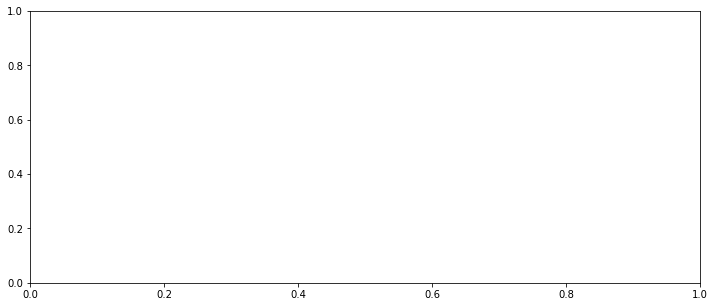

In [33]:
plot_metrcis(statsDict, title="asd")

In [12]:
netFunctionList = [("Easy Net", trainEasyNet), ("LSTM Net", train_lstm)]

epochs = 15
batch_size = 64
verbose = 0
num_classes = 2

statsDict = {}

for net_name, function in netFunctionList:
    print("Evaluating {}".format(net_name))
    
    statsDict[net_name] = {}
    
    print("Online Frequency Data")
    model, loss, accuarcy = function(X_train_freq, y_train_freq, X_test_freq, y_test_freq,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['online_freq_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy}
    
    
    model, loss, accuarcy = function(X_train_entropy, y_train_entropy, X_test_entropy, y_test_entropy,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['online_entropy_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy}
    
    print("Experiement Frequency Data")
    model, loss, accuarcy = function(X_train_freq_exp, y_train_freq_exp, X_test_freq_exp, y_test_freq_exp,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['experiment_freq_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy}
    
    print("Experiement Entropy Data")
    model, loss, accuarcy = function(X_train_entropy_exp, y_train_entropy_exp, X_test_entropy_exp, y_test_entropy_exp,
                                     epochs=epochs, batch_size=batch_size, verbose=verbose)
    statsDict[net_name]['experiment_entropy_data'] = {"model" : model, "loss" : loss, "accuarcy" : accuarcy}

print("Done")

Evaluating Easy Net
Online Frequency Data
Test loss: 1.1378809221916728
Test accuracy: 0.5902777910232544
Test loss: 1.4110502578964943
Test accuracy: 0.5589600801467896
Experiement Frequency Data
Test loss: 1.6079379791133506
Test accuracy: 0.6387096643447876
Experiement Entropy Data
Test loss: 0.6988416079006393
Test accuracy: 0.5778546929359436
Evaluating LSTM Net
Online Frequency Data
Test loss: 1.3613783563659698
Test accuracy: 0.5694444179534912
Test loss: 1.2214424970145565
Test accuracy: 0.5366759300231934
Experiement Frequency Data
Test loss: 1.1481416922743601
Test accuracy: 0.6279569864273071
Experiement Entropy Data
Test loss: 0.7456444809181055
Test accuracy: 0.5640138387680054
Done


In [13]:
statsDict['Easy Net']

{'online_freq_data': {'model': <keras.engine.sequential.Sequential at 0x258e5f60688>,
  'loss': 1.1378809221916728,
  'accuarcy': 0.5902777910232544},
 'online_entropy_data': {'model': <keras.engine.sequential.Sequential at 0x258d362fa88>,
  'loss': 1.4110502578964943,
  'accuarcy': 0.5589600801467896},
 'experiment_freq_data': {'model': <keras.engine.sequential.Sequential at 0x258cf176fc8>,
  'loss': 1.6079379791133506,
  'accuarcy': 0.6387096643447876},
 'experiment_entropy_data': {'model': <keras.engine.sequential.Sequential at 0x258d3e5ad88>,
  'loss': 0.6988416079006393,
  'accuarcy': 0.5778546929359436}}

Epoch 1/10
1008/1008 [==============================] - 0s 471us/step - loss: 3.2995 - accuracy: 0.5258
Epoch 2/10
1008/1008 [==============================] - 0s 357us/step - loss: 0.6450 - accuracy: 0.6230
Epoch 3/10
1008/1008 [==============================] - 0s 330us/step - loss: 0.5557 - accuracy: 0.7222
Epoch 4/10
1008/1008 [==============================] - 0s 333us/step - loss: 0.4948 - accuracy: 0.7788
Epoch 5/10
1008/1008 [==============================] - 0s 337us/step - loss: 0.4586 - accuracy: 0.7956
Epoch 6/10
1008/1008 [==============================] - 0s 342us/step - loss: 0.3816 - accuracy: 0.8313
Epoch 7/10
1008/1008 [==============================] - 0s 347us/step - loss: 0.3965 - accuracy: 0.8264
Epoch 8/10
1008/1008 [==============================] - 0s 333us/step - loss: 0.2886 - accuracy: 0.8730
Epoch 9/10
1008/1008 [==============================] - 0s 337us/step - loss: 0.3082 - accuracy: 0.8532
Epoch 10/10
1008/1008 [==============================] - 0s 372u